In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

from torchviz import make_dot
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
#CONTROL PARAMETERS CELL

name = ["Lagos","Perth"]
seed = 25

split_size = 0.8
batch_size =  40

hidden_layers =  [14,2]
dropout = [0.,0.]
learning_rate = 1e-4

step_size = 50
gamma = 0.75

epochs = 130

In [6]:
#Fixing the seed
np.random.seed(seed)
torch.manual_seed(seed)

#load dataset and labels
data = np.load('Dati/dataset_{}_x_{}.npy'.format(name[0],name[1]))
label = np.load('Dati/labels_{}_x_{}.npy'.format(name[0],name[1]))

#random permutation of dataset 
indices = np.random.permutation(data.shape[0])
data = data[indices]
label = label[indices]

#conversion into torch tensor
data = torch.tensor(data, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.float32)

#reshape of label, it is necessary for later
label = torch.reshape(label, [label.shape[0], 1])

#show the dimension of dataset, 
print( len(data))

1000


In [7]:
#create Dataset and split it into training and validation sets
dataset = TensorDataset(data,label)
train_size = int( split_size * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, worker_init_fn= np.random.seed(seed) )
val_loader = DataLoader(val_dataset, batch_size, shuffle=False , worker_init_fn= np.random.seed(seed))

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [9]:
#define classic net
class BlockLayer(torch.nn.Module):
    def __init__(self,input_feat, output_feat, d_out):
        super(BlockLayer,self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Linear( input_feat, output_feat),
            torch.nn.ReLU(),
            torch.nn.Dropout( d_out )
        )
    def forward(self, x):
        x = self.block(x)
        return x


class ClassicNetwork(torch.nn.Module):
    def __init__(self, hidden_layers, d_out):
        super(ClassicNetwork, self).__init__()
        self.layers = torch.nn.ModuleList()

        self.layers.append( torch.nn.Linear( len(data[0])  , hidden_layers[0]) )
        self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Dropout(d_out[0]))

        for i in range (len(hidden_layers) - 1):
            self.layers.append( BlockLayer( hidden_layers[i], hidden_layers[i+1], d_out[i+1]) )

        last_dim = len(hidden_layers) - 1
        self.layers.append( torch.nn.Linear( hidden_layers[last_dim], 1) )

        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
      
      

In [10]:
model = ClassicNetwork( hidden_layers , dropout )
print(model)

ClassicNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=14, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): BlockLayer(
      (block): Sequential(
        (0): Linear(in_features=14, out_features=2, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
      )
    )
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [11]:
opt = torch.optim.Adam( model.parameters(), learning_rate)
lossFunction = torch.nn.BCEWithLogitsLoss()

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size= step_size, gamma= gamma)

In [12]:
def evaluate_model( model , loader , loss_fn  ):
    
    all_outputs = []
    all_labels = []

    running_loss = 0
    with torch.no_grad():
        for id, (data, label) in enumerate(loader):
            output = model(data)
            loss = loss_fn(output,label)

            running_loss += loss.item()

            all_outputs.append(output)
            all_labels.append(label)

        losses = running_loss/(id+1)
        all_outputs_tensor = torch.cat(all_outputs)
        all_labels_tensor = torch.cat(all_labels)

        predicted = torch.round(all_outputs_tensor)
    
        accuracy = accuracy_score(all_labels_tensor.numpy(), predicted.numpy())

        return accuracy , losses

In [13]:
# This is the actual model training (and validation). It may take a while, depending on:
# epoch number, network architecture, dataset size.

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


# training the model
for i in range(epochs):

    train_running_loss = 0

    model.train()  # Set the model to training mode
    for id_batch, (data, label) in enumerate(train_loader):
        output = model(data)
        loss = lossFunction(output, label)
        loss.backward()
        opt.step()
        opt.zero_grad(set_to_none=True)

        train_running_loss += loss.item()
   
    train_losses.append(train_running_loss/(id_batch+1))
    scheduler.step()
    
    model.eval()
    train_acc , train_loss = evaluate_model( model , train_loader, lossFunction)
    val_acc , val_loss = evaluate_model( model , val_loader, lossFunction)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
      

    print(
        "Epoch: {}\tTraining Loss: {:.4f}\tVal Loss: {:.4f}\tTraining Accuracy: {:.2f}%\tValidation Accuracy: {:.2f}%".format(
            i + 1, train_losses[i], val_loss, 100 * train_acc, 100 * val_acc)
        )
    
print(' ')
print( f'train parameter: ')
print(f'batch_size: {batch_size} \t hidden layer: {hidden_layers} \t dropout: {dropout}')
print(f'lr: {learning_rate} \t step size: {step_size} \t gamma: {gamma}')
print(f'epochs: {epochs}')

Epoch: 1	Training Loss: 0.7199	Val Loss: 0.7341	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 2	Training Loss: 0.7180	Val Loss: 0.7321	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 3	Training Loss: 0.7161	Val Loss: 0.7301	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 4	Training Loss: 0.7142	Val Loss: 0.7282	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 5	Training Loss: 0.7124	Val Loss: 0.7263	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 6	Training Loss: 0.7105	Val Loss: 0.7244	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 7	Training Loss: 0.7088	Val Loss: 0.7226	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 8	Training Loss: 0.7071	Val Loss: 0.7207	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 9	Training Loss: 0.7054	Val Loss: 0.7187	Training Accuracy: 50.50%	Validation Accuracy: 48.00%
Epoch: 10	Training Loss: 0.7037	Val Loss: 0.7168	Training Accuracy: 50.50%	Validat

In [14]:
print(100*max(val_accuracies))

85.5


Text(0, 0.5, 'Loss')

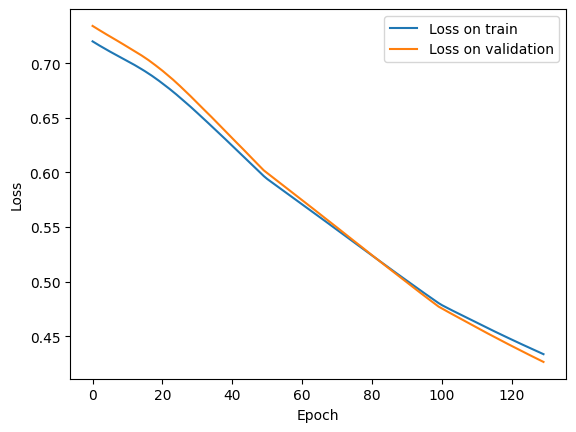

In [15]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Loss on train", "Loss on validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

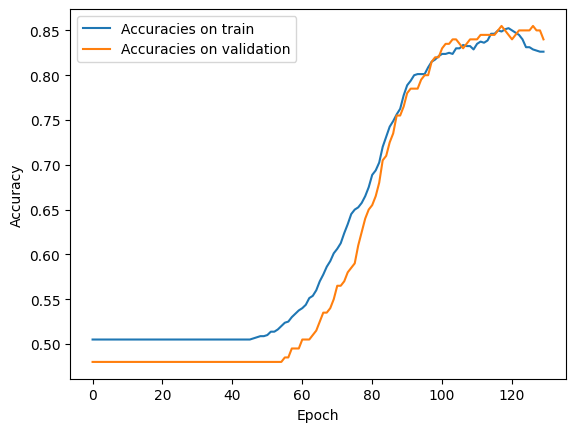

In [16]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.legend(["Accuracies on train", "Accuracies on validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")